# 0. Librerías

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 1. Preparación de datos (ya preprocesados) y de parámetros

In [50]:
X = np.concatenate((np.load('data/x_training.npy'), np.load('data/x_testing.npy')), axis=0)
y = np.concatenate((np.load('data/y_training.npy')[:,0], np.load('data/y_testing.npy')[:,0]), axis=0) - 1  # clases de 0 a 4

X, y = shuffle(X, y, random_state=42)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)


"""
0 = Bottle
1 = Can
2 = Noise
3 = Paper
4 = Ping-pong
"""

INPUT_LENGTH = 4018
NUM_CLASSES = 5
LEARNING_RATE = 0.005

# 2. Architectura del modelo y entrenamiento

In [51]:
model = Sequential([
    Reshape((98, 41), input_shape=(INPUT_LENGTH,)),
    Conv1D(8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Dropout(0.25),
    Conv1D(16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(NUM_CLASSES, activation='softmax', name='y_pred')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 98, 41)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 98, 8)             992       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 49, 8)            0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 49, 8)             0         
                                                                 
 conv1d_13 (Conv1D)          (None, 49, 16)            400       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                 

In [52]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=2
)

Epoch 1/200
6/6 - 0s - loss: 1.5624 - accuracy: 0.1600 - val_loss: 1.4799 - val_accuracy: 0.2045 - 312ms/epoch - 52ms/step
Epoch 2/200
6/6 - 0s - loss: 1.4409 - accuracy: 0.2514 - val_loss: 1.3990 - val_accuracy: 0.3409 - 21ms/epoch - 4ms/step
Epoch 3/200
6/6 - 0s - loss: 1.3532 - accuracy: 0.3829 - val_loss: 1.3118 - val_accuracy: 0.4545 - 21ms/epoch - 3ms/step
Epoch 4/200
6/6 - 0s - loss: 1.2484 - accuracy: 0.4057 - val_loss: 1.1040 - val_accuracy: 0.7045 - 22ms/epoch - 4ms/step
Epoch 5/200
6/6 - 0s - loss: 1.1155 - accuracy: 0.5543 - val_loss: 0.9795 - val_accuracy: 0.7045 - 19ms/epoch - 3ms/step
Epoch 6/200
6/6 - 0s - loss: 0.8929 - accuracy: 0.7314 - val_loss: 0.6978 - val_accuracy: 0.8182 - 20ms/epoch - 3ms/step
Epoch 7/200
6/6 - 0s - loss: 0.6863 - accuracy: 0.7771 - val_loss: 0.4956 - val_accuracy: 0.9091 - 19ms/epoch - 3ms/step
Epoch 8/200
6/6 - 0s - loss: 0.6212 - accuracy: 0.7829 - val_loss: 0.3807 - val_accuracy: 0.9545 - 21ms/epoch - 3ms/step
Epoch 9/200
6/6 - 0s - loss: 0

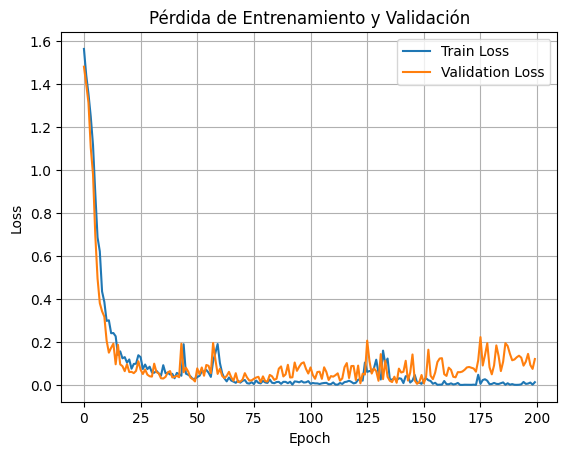

In [53]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()

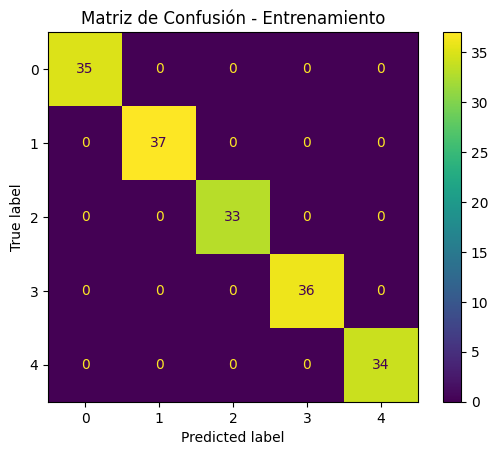

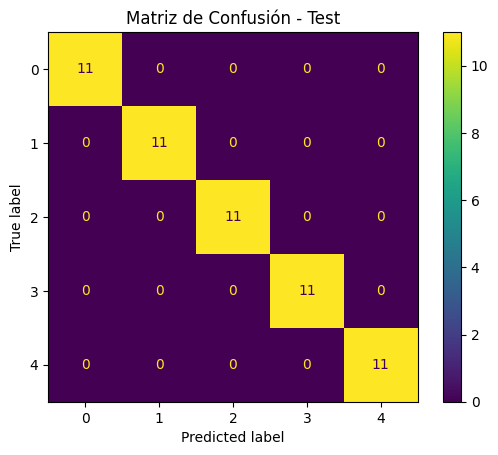

In [54]:
# Para TRAIN
y_pred_train = np.argmax(model.predict(X_train),axis=1)
cm_train = confusion_matrix(y_train, y_pred_train)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Matriz de Confusión - Entrenamiento")
plt.show()

# Para TEST
y_pred_test = np.argmax(model.predict(X_test), axis=1)
cm_test = confusion_matrix(y_test, y_pred_test)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Matriz de Confusión - Test")
plt.show()

# 3. Exportación al ESP32

In [55]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo
with open("model_float32.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0f1cxnkx/assets


INFO:tensorflow:Assets written to: /tmp/tmp0f1cxnkx/assets
2025-06-25 06:44:53.447682: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2025-06-25 06:44:53.447701: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2025-06-25 06:44:53.447832: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp0f1cxnkx
2025-06-25 06:44:53.448888: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2025-06-25 06:44:53.448903: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmp0f1cxnkx
2025-06-25 06:44:53.452177: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2025-06-25 06:44:53.475586: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmp0f1cxnkx
2025-06-25 06:44:53.484068: I tensorflow/cc/saved_model/loader.cc:283] SavedMode